In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [3]:
df = pd.read_csv(r'c:\Users\Administrator\Downloads\Food_orders.csv')
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [5]:
df.dtypes

Order ID                   int64
Customer ID               object
Restaurant ID             object
Order Date and Time       object
Delivery Date and Time    object
Order Value                int64
Delivery Fee               int64
Payment Method            object
Discounts and Offers      object
Commission Fee             int64
Payment Processing Fee     int64
Refunds/Chargebacks        int64
dtype: object

The dataset contains 1,000 entries and 12 columns,  Now, we need to perform some data cleaning and preparation. Below are the necessary cleaning steps we need to take:

Convert “Order Date and Time” and “Delivery Date and Time” to a datetime format.
Convert “Discounts and Offers” to a consistent numeric value (if applicable) or calculate the discount amounts.
Ensure all monetary values are in a suitable format for calculations.

In [6]:
df.isnull().sum()

Order ID                    0
Customer ID                 0
Restaurant ID               0
Order Date and Time         0
Delivery Date and Time      0
Order Value                 0
Delivery Fee                0
Payment Method              0
Discounts and Offers      185
Commission Fee              0
Payment Processing Fee      0
Refunds/Chargebacks         0
dtype: int64

Discounts and Offers column as 185 null values so we need handle the null values by completly deleting that rows or column or replacing that values with meadian or mode 

In [7]:
df['Discounts and Offers'].mode() # its is a object 

0    10%
Name: Discounts and Offers, dtype: object

In [8]:
df['Discounts and Offers'] = df['Discounts and Offers'].fillna(df['Discounts and Offers'].mode()[0])
df.isnull().sum()

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
dtype: int64

In [9]:
# Lets perform the cleaning operations 
# Convert “Order Date and Time” and “Delivery Date and Time” to a datetime format.
from datetime import datetime 
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])
df.dtypes

Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
dtype: object

In [10]:
# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

In [11]:
# apply the function to create a new 'Discount Value' column
df['Discount Percentage'] = df['Discounts and Offers'].apply(lambda x: extract_discount(x))

In [12]:
df['Discount Amount'] = df.apply(lambda x:(x['Order Value']*x['Discount Percentage']/100)if x['Discount Percentage']>1 else x['Discount Percentage'],axis=1)
df['Discount Amount'] = df.apply(lambda x:(x['Order Value']) if x['Discount Percentage'] <= 1 else x['Order Value']*x['Discount Percentage']/100,axis = 1)

In [13]:
df[['Order Value','Discount Percentage','Discount Amount']].head()

,Order Value,Discount Percentage,Discount Amount
0,1914,5.0,95.70
1,986,10.0,98.60
2,937,15.0,140.55
3,1463,10.0,146.30
4,1992,50.0,996.00


Order Date and Time and Delivery Date and Time columns have been converted to datetime format.

A new column, Discount Amount, has been calculated based on the Discounts and Offers column.

This was achieved by extracting percentage discounts or fixed amounts and applying them to the order value.

Discount Percentage has been added to represent the discount rate or fixed amount discount directly.

## Cost and Profitability Analysis

For the cost analysis, we’ll consider the following costs associated with each order:

Delivery Fee: The fee charged for delivering the order.
Payment Processing Fee: The fee for processing the payment.
Discount Amount: The discount provided on the order.
We’ll calculate the total cost for the platform per order and then aggregate this data to understand the overall cost structure.

The revenue for the platform is mainly derived from the Commission Fee. We’ll calculate the net profit by subtracting the total costs (including discounts) from the revenue generated through commission fees.

In [14]:
# calculate total costs and revenue per order
df['Total Cost'] = df['Delivery Fee'] + df['Discount Amount'] + df['Payment Processing Fee']
df['revenue'] = df['Commission Fee']
df['Profit'] = df['revenue'] - df['Total Cost']


In [15]:
# aggregate data to get overall metrics
total_orders = df.shape[0]
total_revenu = df['revenue'].sum()
total_cost = df['Total Cost'].sum()
total_profit = df['Profit'].sum()

all_metrics = {
    'Total_orders':total_orders,
    'Total_revenu':total_revenu,
    'Total_cost':total_cost,
    'Total_profit':total_profit
}

Metrics = {k: int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for k, v in all_metrics.items()}
Metrics

{'Total_orders': 1000,
 'Total_revenu': 126990,
 'Total_cost': 252095.55,
 'Total_profit': -125105.55}

 Based on the analysis, here are the overall metrics for the food delivery operations:


Total Orders: 1,000
Total Revenue (from Commission Fees): 126,990 INR
Total Costs: 232,709.85 INR (including delivery fees, payment processing fees, and discounts)
Total Profit: -105,719.85 INR

The analysis indicates that the total costs associated with the food delivery operations exceed the total revenue generated from commission fees, resulting in a net loss. It suggests that the current commission rates, delivery fees, and discount strategies might not be sustainable for profitability.

To better understand the distribution of costs, revenue, and profit, let’s plot:

A histogram of profits per order to visualize the distribution of profitable and unprofitable orders.


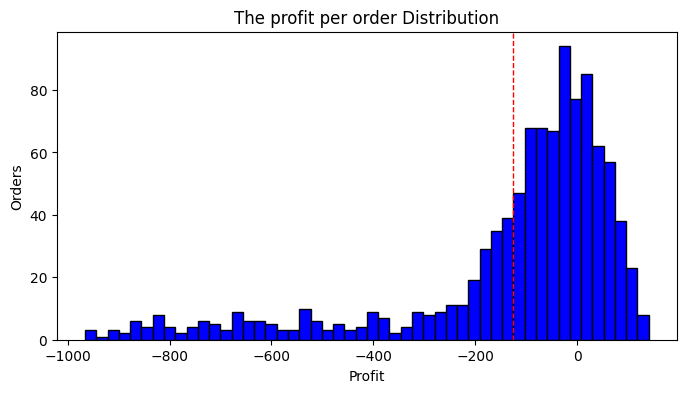

In [16]:
# Histogram plot to know the distribution of the profit per order
plt.figure(figsize=(8,4))
plt.hist(df['Profit'],bins=50,color='b',edgecolor = 'k')
plt.title('The profit per order Distribution')
plt.xlabel('Profit')
plt.ylabel('Orders')
plt.axvline(df['Profit'].mean(),color = 'red',linestyle = 'dashed',linewidth = 1)
plt.show()

The histogram shows a wide distribution of profit per order, with a noticeable number of orders resulting in a loss (profits below 0). The red dashed line indicates the average profit, which is in the negative territory, highlighting the overall loss-making situation.

In [17]:
df.dtypes

Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount                  float64
Total Cost                       float64
revenue                            int64
Profit                           float64
dtype: object

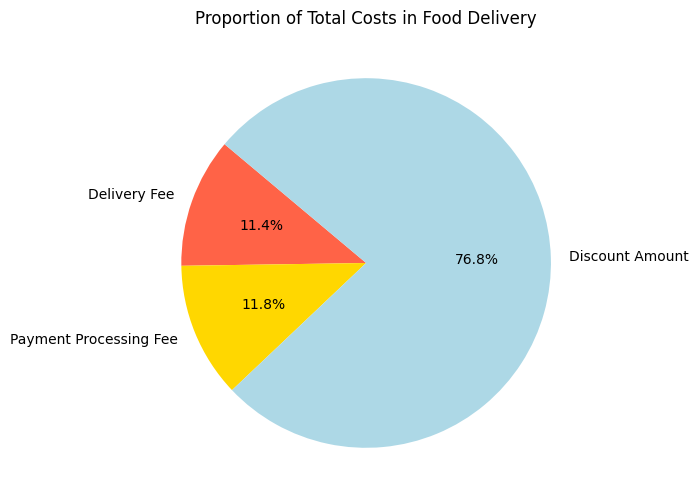

In [18]:
# A pie chart to visualize the proportion of total costs (delivery fees, payment processing fees, andm discounts).
costs_breakdown = df[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(6, 6))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

 The pie chart illustrates the breakdown of total costs into delivery fees, payment processing fees, and discount amounts. Discounts constitute a significant portion of the costs, suggesting that promotional strategies might be heavily impacting overall profitability.

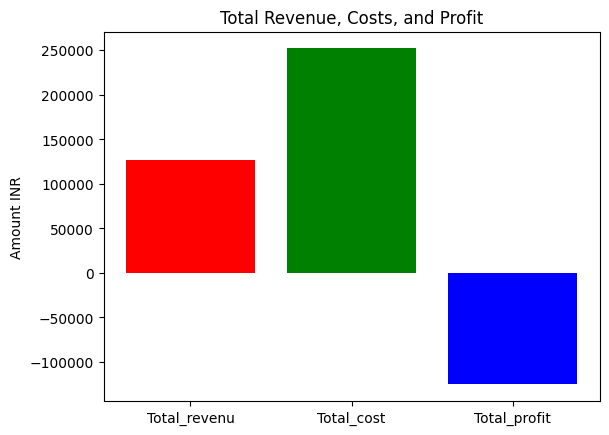

In [19]:
# Now lets compare the total cost, total profit, total revenue by using the bar plot
total = ['Total_revenu','Total_cost','Total_profit']
values = [total_revenu,total_cost,total_profit]
plt.Figure(figsize=(8,6))
plt.bar(total,values,color = ['red','green','blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount INR')
plt.show()

The bar chart compares total revenue, total costs, and total profit. It visually represents the gap between revenue and costs, clearly showing that the costs surpass the revenue, leading to a total loss.

# A New Strategy for Profits

From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply. Specifically, we need to look for:

A new average commission percentage based on profitable orders.
A new average discount percentage for profitable orders, that could serve as a guideline for what level of discount still allows for profitability.

Given these new averages, we can suggest adjustments that might not only make individual orders profitable but also apply broadly across all orders to improve overall profitability. Let’s calculate:

The average commission percentage for profitable orders.
The average discount percentage for profitable orders.

In [20]:
# Filter the dataset based on the profit orders 
profitable_orders = df[df['Profit'] > 0]

In [21]:
# calculating the commission fees percentage for profit orders 
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee']/profitable_orders['Order Value'])*100

# calculating the Discount percentage for profitable orders 
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount']/profitable_orders['Order Value'])*100

#Calculating the new averages 
new_commission_percentage_average = profitable_orders['Commission Percentage'].mean()
new_discount_percenatge_average = profitable_orders['Effective Discount Percentage'].mean()

#Printing the avearges 
# print(new_commission_percentage_average,new_discount_percenatge_average)

In [22]:
# filter the dataset for profitable orders
profitable_orders = df[df['Profit'] > 0]

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)

37.99993176163184 9.950657894736842


Based on the analysis of profitable orders, we find a new set of averages that could represent a “sweet spot” for commission and discount percentages:

New Average Commission Percentage: 37.99%

New Average Discount Percentage: 9.95%

The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 37% and a discount rate around 9% could potentially improve profitability across the board.

Now, let’s visualize a comparison of profitability using actual versus recommended discounts and commissions across all orders. For this, we need to:

1 Calculate the profitability per order using the actual discounts and commissions already present in the dataset.

2 Simulate profitability per order using the recommended discounts (9%) and commissions (37%) to see the potential impact on profitability.

This comparison will help illustrate the potential impact of adopting the recommended discount and commission rates on the overall profitability of orders.

In [23]:
# The recommanded Discount and Commssion fees Percentages
recommanded_commission_fee_percentage  = 37.0 
recommanded_discount_amount_percentage = 9.0 

# Calculating the estimated commission fee and discount amount 
df['Estimated commission fee'] = df['Order Value']*(recommanded_commission_fee_percentage/100)
df['Estimated discount amount'] = df['Order Value']*(recommanded_discount_amount_percentage/100)


In [24]:
# Recalculating the the Total costs and profit by using the estimated dicount amount and commission fees 
df['Estimated total cost'] = (df['Delivery Fee']+df['Payment Processing Fee']+df['Estimated discount amount'])
df['Estimated Profit'] = (df['Estimated commission fee'] - df['Estimated total cost'])


In [25]:
print(df[['Total Cost','Estimated total cost','Profit','Estimated Profit']])

     Total Cost  Estimated total cost  Profit  Estimated Profit
0        142.70                219.26    7.30            488.92
1        161.60                151.74   36.40            213.08
2        215.55                159.33  -20.55            187.36
3        223.30                208.67  -77.30            332.64
4       1076.00                259.28 -946.00            477.76
..          ...                   ...     ...               ...
995       88.25                121.25   76.75            184.00
996      254.70                238.43 -144.70            363.56
997      106.30                100.77  -42.30            103.84
998      246.10                161.26  -47.10            361.92
999      295.55                196.13 -115.55            416.96

[1000 rows x 4 columns]


## Visulazing the Comaprsion between the Actual Profit and Estimated Profit 

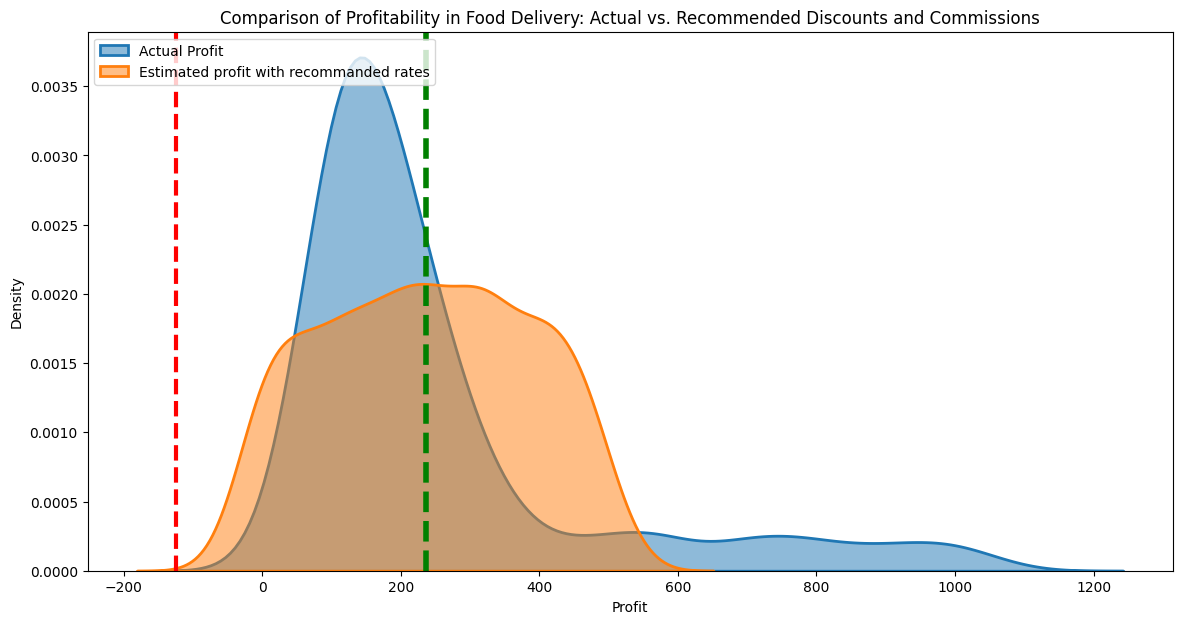

In [26]:
# for comaprison we need the kde plot
import seaborn as sns
plt.figure(figsize=(14,7))

# Actual Profit 
sns.kdeplot(df['Total Cost'],label='Actual Profit',linewidth = 2,fill = True,alpha=0.5)

# Estimated Profit 
sns.kdeplot(df['Estimated Profit'],label = 'Estimated profit with recommanded rates',fill = True,alpha = 0.5,linewidth = 2)
plt.axvline(df['Profit'].mean(),color = 'red',linestyle = 'dashed',linewidth = 3)
plt.axvline(df['Estimated Profit'].mean(),color = 'g',linestyle = 'dashed',linewidth = 4)
plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()




The visualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts (9%) and commissions (37%)

The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders

1.The Red line show that the average Actual profit.

2.The Green line show that the average estimated profit with recommanded discount percentage and recommanded commission fees.